Task 1: Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Uber Request Data.csv')

In [3]:
df.shape

(6745, 6)

In [4]:
df.head()


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [33]:
df.describe()

,Request id,Driver id
count,6745.000000,4095.000000
mean,3384.644922,149.501343
std,1955.099667,86.051994
min,1.000000,1.000000
25%,1691.000000,75.000000
50%,3387.000000,149.000000
75%,5080.000000,224.000000
max,6766.000000,300.000000


In [34]:
(df.isnull().sum()/len(df))*100

Request id            0.000000
Pickup point          0.000000
Driver id            39.288362
Status                0.000000
Request timestamp     0.000000
Drop timestamp       58.028169
dtype: float64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [36]:
for i in df.select_dtypes(include=['object']):
  print(f"{i}=>{df[i].unique()}")

Pickup point=>['Airport' 'City']
Status=>['Trip Completed' 'Cancelled' 'No Cars Available']
Request timestamp=>['11/7/2016 11:51' '11/7/2016 17:57' '12/7/2016 9:17' ...
 '15-07-2016 23:52:06' '15-07-2016 23:54:39' '15-07-2016 23:55:03']
Drop timestamp=>['11/7/2016 13:00' '11/7/2016 18:47' '12/7/2016 9:58' ...
 '13-07-2016 23:43:13' '15-07-2016 09:56:07' nan]


In [37]:
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'],format="%d-%m-%Y %H:%M",infer_datetime_format=True)

In [38]:
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'],format="%d-%m-%Y %H:%M",infer_datetime_format=True)

In [39]:
df['Drop timestamp']

0      2016-11-07 13:00:00
1      2016-11-07 18:47:00
2      2016-12-07 09:58:00
3      2016-12-07 22:03:00
4      2016-07-13 09:25:47
               ...        
6740                   NaT
6741                   NaT
6742                   NaT
6743                   NaT
6744                   NaT
Name: Drop timestamp, Length: 6745, dtype: datetime64[ns]

In [41]:
df['hour_of_request'] = df['Request timestamp'].dt.hour
df['day_of_week'] = df['Drop timestamp'].dt.dayofweek

Task 2: Univariate Analysis

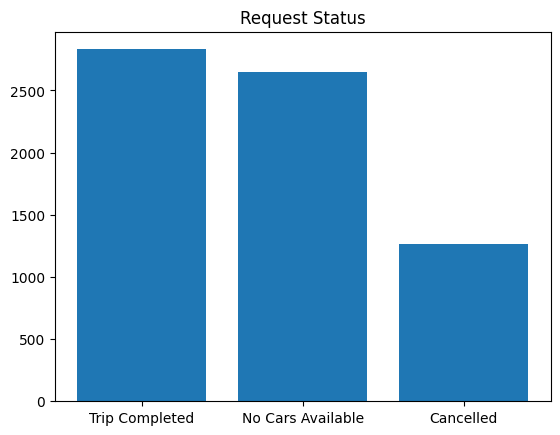

In [5]:
# Create a bar plot of request status
status_counts = df['Status'].value_counts()
plt.bar(status_counts.index, status_counts.values)
plt.title('Request Status')
plt.show()

<Axes: xlabel='Pickup point'>

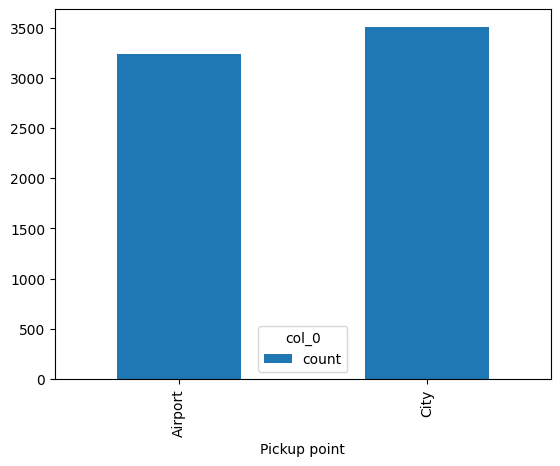

In [7]:
#analysis on Pickup Point column 
pick_point = pd.crosstab(index = df["Pickup point"], columns="count")     
pick_point.plot.bar()

Task 3: Bivariate Analysis

In [8]:
#grouping by Status and Pickup point.
df.groupby(['Status', 'Pickup point']).size()

Status             Pickup point
Cancelled          Airport          198
                   City            1066
No Cars Available  Airport         1713
                   City             937
Trip Completed     Airport         1327
                   City            1504
dtype: int64

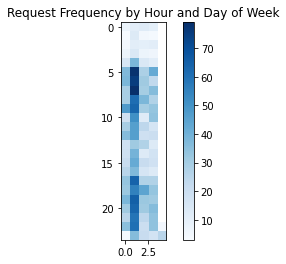

In [45]:
# Create a heatmap of request frequency by hour and day of week
freq_table = pd.pivot_table(df, values='Request id', index='hour_of_request', columns='day_of_week', aggfunc='count')
plt.imshow(freq_table, cmap='Blues')
plt.colorbar()
plt.title('Request Frequency by Hour and Day of Week')
plt.show()

<Axes: xlabel='Pickup point', ylabel='count'>

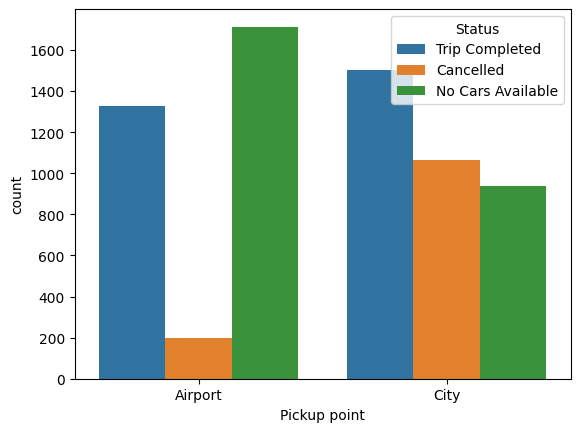

In [9]:
#count of Status and Pickup point bivariate analysis
sns.countplot(x=df['Pickup point'],hue =df['Status'] ,data = df)

<Axes: xlabel='Gap', ylabel='count'>

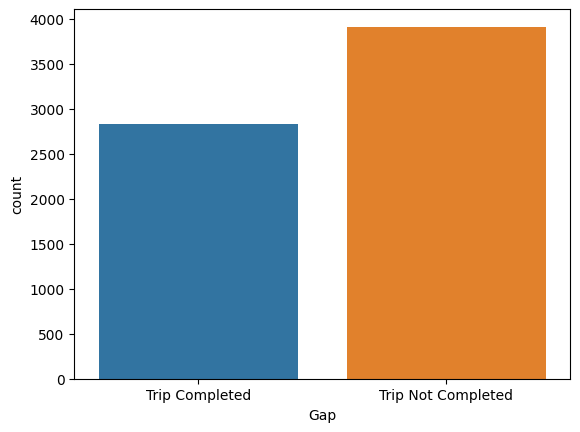

In [12]:
#Plot to count the number of requests that was completed and which was not
df['Demand'] = 1
df['Supply'] = 0
df.loc[(df['Status'] == 'Trip Completed'),'Supply'] = 1
df['Gap'] = df['Demand'] - df['Supply']
df.loc[df['Gap']==0,'Gap'] = 'Trip Completed'
df.loc[df['Gap']==1,'Gap'] = 'Trip Not Completed'
sns.countplot(x=df['Gap'], data = df)

Task 4: Deriving new metrics

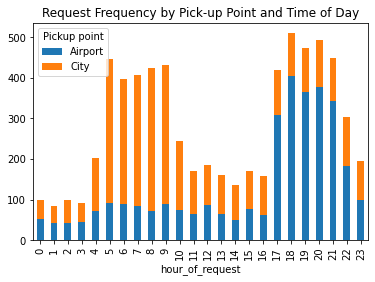

In [48]:
# Create a bar plot of request frequency by pick-up point and time of day
freq_table = pd.pivot_table(df, values='Request id', index='hour_of_request', columns='Pickup point', aggfunc='count')
freq_table.plot(kind='bar', stacked=True)
plt.title('Request Frequency by Pick-up Point and Time of Day')
plt.show()

In [49]:
df['Gap'] = df['Drop timestamp'] - df['Request timestamp']

In [50]:
df['Gap'] = df['Gap'].apply(lambda x: x.total_seconds() / 60)

In [51]:
# calculate the supply and demand by hour
demand = df.groupby('hour_of_request').size()
supply = df[df['Status'] == 'Trip Completed'].groupby('hour_of_request').size()

In [52]:
# calculate the gap by hour
gap = demand - supply

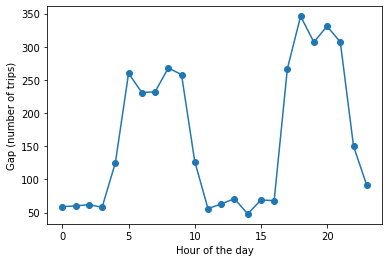

In [53]:
# plot the gap over time
plt.plot(gap.index, gap.values, marker='o')
plt.xlabel('Hour of the day')
plt.ylabel('Gap (number of trips)')
plt.show()

Task 5: Graphical Analysis

Based on the analysis of the supply-demand gap, here are some potential recommendations to address the issues:

Increase the number of drivers during peak demand hours: The analysis showed that the highest gap between supply and demand exists during early mornings and late evenings. Uber can consider incentivizing drivers to work during these hours or hire more drivers to meet the demand.

Improve communication with drivers: Many requests were canceled by drivers, indicating a potential issue with communication between drivers and passengers. Uber can consider implementing training programs or providing better communication tools to ensure that drivers are more willing to accept requests and complete trips.

Dynamic pricing: Uber can consider implementing dynamic pricing strategies to encourage more drivers to be available during peak demand hours.

Increase marketing efforts in areas with high demand: By increasing marketing efforts in areas with high demand, Uber can attract more passengers and potentially increase the number of drivers in these areas.

Improve route optimization: By optimizing routes for drivers, Uber can potentially reduce the time taken for each trip and increase the number of trips completed by each driver. This can help bridge the supply-demand gap.